In [1]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
    
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
class CIFAR10(object):
    def __init__(self):
        from keras.datasets import cifar10
        (train_x, train_y), (test_x, test_y) = cifar10.load_data()
        self.train_x =  train_x.astype('float32')/255
        self.train_y = train_y.astype('float32')/255
        self.test_x = test_x.astype('float32')/255
        self.test_y = test_y.astype('float32')/255

In [3]:
class Model(object):
    def __init__(self, n1, n2, n3, nh, reg):
        self.reg = reg
        self.sizes = [n1, n2, n3, nh]
        self.hourglass()

    def hourglass(self):
        from keras import regularizers
        from keras.models import Sequential
        from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, UpSampling2D
        from keras.layers import Activation, Flatten, Dense, Dropout, Reshape
        
        reg = self.reg
        r=lambda: regularizers.l2(reg)
        (n1, n2, n3, nh) = self.sizes
        model = Sequential()
        def L(n, in_shape=None):
            if in_shape is not None:
                model.add(Conv2D(n, (3,3), padding="same", input_shape=in_shape, 
                                 kernel_regularizer=r(), bias_regularizer=r()))
            else:
                model.add(Conv2D(n, (3,3), padding="same", 
                                 kernel_regularizer=r(), bias_regularizer=r()))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2,2)))

        def M(n):
            model.add(Conv2D(n, (3,3), padding="same", 
                             kernel_regularizer=r(), bias_regularizer=r()))
            model.add(Activation('relu'))
            model.add(UpSampling2D((2,2)))

        L(n1, in_shape=(3,32,32))
        L(n2)
        L(n3)
        model.add(Flatten())
        model.add(Dense(nh, kernel_regularizer=r(), bias_regularizer=r()))
        # activations???
        model.add(Activation('relu'))
        model.add(Dense(n3*4*4, kernel_regularizer=r(), bias_regularizer=r()))
        model.add(Reshape((n3,4,4)))
        M(n3)
        M(n2)
        M(n1)
        model.add(Conv2D(3, (3, 3), padding="same"))
        model.add(Activation('relu'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        ll = model.layers
        
        self.model = model
        self.eval_hidden = K.function([ll[0].input], [ll[10].output])
        
    def fit(self, data, epochs=1, verbose=1):
         self.model.fit(data.train_x, data.train_x, batch_size=256,
                        validation_data=(data.test_x, data.test_x), 
                        epochs=epochs, verbose=verbose)
            
    def comp(self, i, model, feat):
        from matplotlib import pyplot as plt
        plt.figure()
        plt.imshow(np.clip(np.transpose(feat[i], (1,2,0)),0,1))
        plt.figure()
        plt.imshow(np.clip(np.transpose(self.model.predict(feat[i:(i+1),:])[0], (1,2,0)), 0, 1))

In [4]:
m = Model(256, 128, 64, 128, 0)
d = CIFAR10()

In [12]:
m.fit(d, epochs=1000)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 39s 790us/step - loss: 0.0093 - val_loss: 0.0090
Epoch 2/1000
50000/50000 [==============================] - 40s 791us/step - loss: 0.0092 - val_loss: 0.0096
Epoch 3/1000
50000/50000 [==============================] - 40s 797us/step - loss: 0.0090 - val_loss: 0.0088
Epoch 4/1000
50000/50000 [==============================] - 40s 796us/step - loss: 0.0090 - val_loss: 0.0091
Epoch 5/1000
50000/50000 [==============================] - 40s 796us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 6/1000
50000/50000 [==============================] - 40s 795us/step - loss: 0.0088 - val_loss: 0.0086
Epoch 7/1000
50000/50000 [==============================] - 40s 800us/step - loss: 0.0087 - val_loss: 0.0087
Epoch 8/1000
50000/50000 [==============================] - 40s 796us/step - loss: 0.0086 - val_loss: 0.0085
Epoch 9/1000
50000/50000 [==============================] - 40s 797us/step - l

KeyboardInterrupt: 

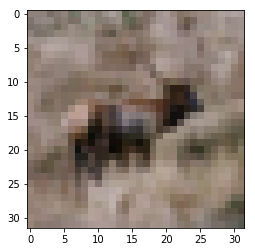

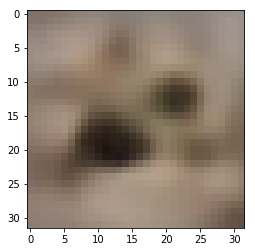

In [13]:
m.comp(np.random.randint(d.test_x.shape[0])
    ,None, d.test_x)

In [ ]:
d.test_x[1,:]